# VGG

This notebook is an implement of [___Very Deep Convolutional Networks for Large-Scale Image Recognition___](https://arxiv.org/pdf/1409.1556.pdf) by Simonyan et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and is better for storing on cluster and training the model.

We first need to install and import all the dependent libraries in the session.

In [1]:
# For pip users
# ! pip install -r ../requirements.txt
# For conda users
! conda install --file ../requirements.txt -y

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

from utilities import getCifar
from utilities import show_training_accuracy, show_Cifar_validation_result

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Solving environment: done

# All requested packages already installed.



2022-05-30 13:09:39.873715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10795 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0035:03:00.0, compute capability: 7.0


This is function that constructs a VGG model. We provide VGG with layers 11, 13, 16, and 19, which are provided in the paper. The structure of the model is almost same with the original paper, but the kernel size and strides are adjusted to fit the smaller pictures of Cifar 10. We define two variables, weight_decay and dropout_rate, as the hyperparameters of the model for kernel regularization and dropout layer, respectively.

In [2]:
def add_layer(model, num_filters, num_layers, weight_decay):
    for i in range(num_layers):
        model.add(Conv2D(filters = num_filters, kernel_size = (3, 3), padding = "same",
            kernel_regularizer = l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))

    model.add(MaxPooling2D(pool_size = 2, strides = 2))

def createVGG(type, weight_decay, dropout_rate):
    if type == 11:
        params = [1, 1, 2, 2, 2]
    elif type == 13:
        params = [2, 2, 2, 2, 2]
    elif type == 16:
        params = [2, 2, 3, 3, 3]
    elif type == 19:
        params = [2, 2, 4, 4, 4]
    else:
        raise Exception("The parameter is not valid!")

    model = tf.keras.Sequential()

    model.add(InputLayer(input_shape = (32, 32, 3)))
    model.add(Resizing(64, 64))
    model.add(RandomRotation(.3))
    model.add(RandomFlip("horizontal"))
    model.add(RandomTranslation((-.3, .3), (-.3, .3)))
    add_layer(model, 64, params[0], weight_decay)
    add_layer(model, 128, params[1], weight_decay)
    add_layer(model, 256, params[2], weight_decay)
    add_layer(model, 512, params[3], weight_decay)
    add_layer(model, 512, params[4], weight_decay)

    model.add(Flatten());
    model.add(Dense(512, kernel_regularizer = l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation = "softmax"))

    return model

In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set and test set.

In [3]:
batch_size = 64

train, val, test = getCifar(batch_size)

2022-05-30 13:09:41.361667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10795 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0035:03:00.0, compute capability: 7.0


This part trains the VGG model on Cifar 10 dataset. We tested several sets of hyperparameters and adopted one with the best validation loss. We then store the best weights of each training epochs on drive so that we can continue training even if the session disconnects. We also store searching results and training weights in case the process takes too much time or the session crashes accidentally. We show the result of the training process with a graph about the training and validation accuracy for each epoch. 

Epoch 1/150


2022-05-30 13:09:46.707672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


625/625 [==============================] - 34s 46ms/step - loss: 7.9395 - accuracy: 0.2796 - val_loss: 7.5522 - val_accuracy: 0.3384 - lr: 1.0000e-04
Epoch 2/150
625/625 [==============================] - 28s 45ms/step - loss: 7.3092 - accuracy: 0.3533 - val_loss: 6.9205 - val_accuracy: 0.4036 - lr: 1.0000e-04
Epoch 3/150
625/625 [==============================] - 28s 45ms/step - loss: 6.6503 - accuracy: 0.3932 - val_loss: 6.2163 - val_accuracy: 0.4311 - lr: 1.0000e-04
Epoch 4/150
625/625 [==============================] - 28s 45ms/step - loss: 5.9337 - accuracy: 0.4200 - val_loss: 5.4807 - val_accuracy: 0.4469 - lr: 1.0000e-04
Epoch 5/150
625/625 [==============================] - 28s 45ms/step - loss: 5.1902 - accuracy: 0.4535 - val_loss: 4.8149 - val_accuracy: 0.4823 - lr: 1.0000e-04
Epoch 6/150
625/625 [==============================] - 28s 45ms/step - loss: 4.4760 - accuracy: 0.4841 - val_loss: 4.2554 - val_accuracy: 0.4775 - lr: 1.0000e-04
Epoch 7/150
625/625 [===================

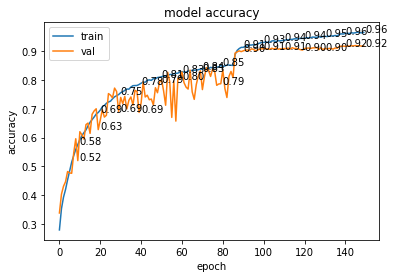

In [4]:
# Set a checkpoint to save weights
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "loss", verbose = 0, save_best_only = True, mode = "auto")
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10, 
                                          verbose = 0, mode = 'auto', min_delta = 0.0001, cooldown = 5, min_lr = 1e-8)
# Hyperparameters
weight_decay = 1e-3
dropout_rate = .5
learning_rate = 1e-4

# Create VGG-19 model
model = createVGG(19, weight_decay, dropout_rate)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights")

history = model.fit(train, epochs = 150, validation_data = val, callbacks = [lr])

show_training_accuracy(history)

Here we test our model on test set and show how VGG predicts on sample images in the test set.

157/157 [==============================] - 2s 13ms/step - loss: 0.5563 - accuracy: 0.9175
Test Accuracy: 91.75%


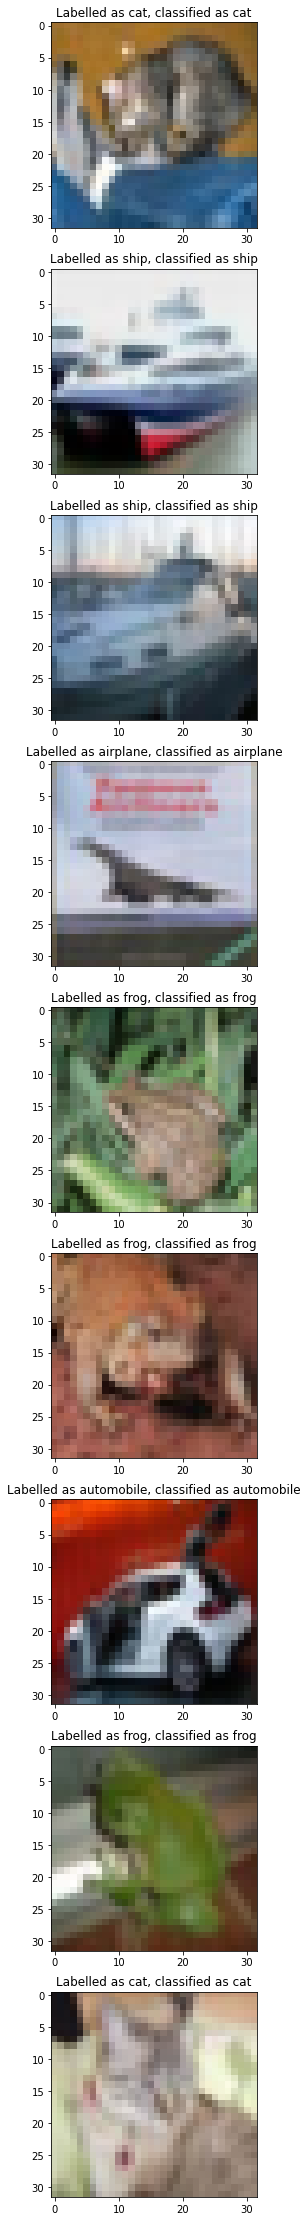

In [5]:
show_Cifar_validation_result(model, test)